In [1]:
# librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [3]:
def count_trips_mibici(data_user, threshold = 5):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    return viajes_user

def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

def encontrar_estacion(est, matriz):
    for i in range(len(matriz)):
        if matriz[i][0] == est:
            return matriz[i][1], matriz[i][2]
    return None, None

In [4]:
# Load data
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')
data = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01')]
del data_2019
estaciones = leer_matriz(f'{dir}/Adj_mibici/matrices_estaciones/est_2019.txt')
#estaciones = leer_matriz('/Users/antoniomendez/Desktop/Tesis/Datos/Adj_mibici/matrices_estaciones/est_2019.txt')

In [6]:
users_counts = data['Usuario_Id'].value_counts()
users = users_counts.index.tolist()

In [ ]:
def compute_entropy_normalized(counter_user):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    entropy: float with the entropy
    '''
    entropy = 0
    for i in range(len(counter_user)):
        prob = counter_user.iloc[i]['prob']
        entropy -= prob * np.log(prob)
    if len(counter_user) > 1:
        entropy /= np.log(len(counter_user))
    else:
        entropy = None
    return entropy

In [30]:
entropies = []
users_to_analize = []
for user in users:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    if len(counter_user) > 0:
        entropies.append(compute_entropy_normalized(counter_user))
        users_to_analize.append(user)

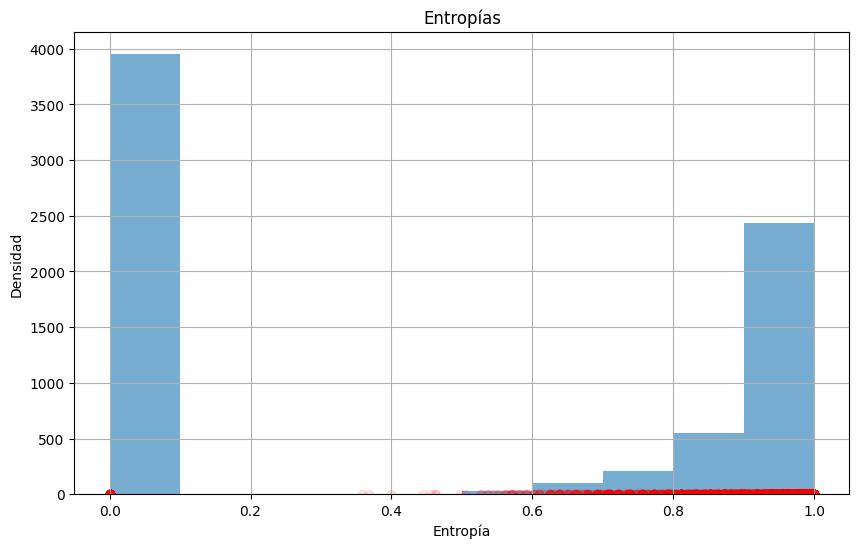

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=10, alpha=0.6)
plt.scatter(entropies, np.zeros(len(entropies)), color='red', alpha=0.1)
plt.xlabel('Entropía')
plt.ylabel('Densidad')
plt.title('Entropías')
plt.grid()
plt.show()

In [32]:
entr_0 = []
for user in users_to_analize:
    if entropies[np.where(np.array(users_to_analize) == user)[0][0]] == 0:
        entr_0.append(user)

In [35]:
len(users)

17433

In [34]:
len(users_to_analize), len(entr_0)

(7279, 3951)

In [33]:
len(entr_0)

3951

In [36]:
entr_0 = np.array(entr_0)
entr_0[:15]

array([275435,  10654, 420420, 445621, 365057, 120126, 310005,  61706,
       454344, 214514, 333176, 442274, 414202, 407715,  33044])

In [41]:
counter_user_275435 = count_trips_mibici(data[data['Usuario_Id'] == 275435])
counter_user_275435

,Est_A,Est_B,counts,prob
143,194,199,5,1.0


In [37]:
counter_user_10654 = count_trips_mibici(data[data['Usuario_Id'] == 10654])
counter_user_10654

,Est_A,Est_B,counts,prob
61,65,73,8,1.0


In [38]:
counter_user_420420 = count_trips_mibici(data[data['Usuario_Id'] == 420420])
counter_user_420420

,Est_A,Est_B,counts,prob
38,31,56,5,1.0


In [42]:
counter_user_445621 = count_trips_mibici(data[data['Usuario_Id'] == 445621])
counter_user_445621

,Est_A,Est_B,counts,prob
62,110,266,5,1.0
